In [1]:
from typing import List, Any, Callable

from pint import UnitRegistry
from scipy import interpolate
import numpy as np
import tabulate
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Инициируем работу с единицами измерения
ureg = UnitRegistry()
Q = ureg.Quantity


ureg.define("person=people")
Person = People = Q(1, "person")

In [3]:
# Входные параметры:
# 1. Жилая площадь
living_area = 60*ureg.meter**2
ceiling_height = 2.6*ureg.meter

# 2. Количество людей
people_count = 3*People

# 3. Температура
street_temp = Q(-40, ureg.celsius)
internal_temp = Q(24, ureg.celsius)
supply_air_temp = Q(15, ureg.celsius)

# 4. Параметры воздухообмена
required_air_per_person = 30 * ureg.meter**3/(Person*ureg.hour)
living_space_airflow_k = 1 * 1/ureg.hour

# 5. Параметры влажности воздуха
required_humidity = 40*ureg.percent
# 6. Начальная температура воды
water_starting_temp = Q(10, ureg.celsius)

In [4]:
# Табличные величины
# Воздух
air_specific_heat = 1030.00 * ureg.joule/(ureg.kg*ureg.kelvin)
air_mole_weight = 29*ureg.gram/ureg.mole
air_mole_volume = 22.4*ureg.liter/ureg.mole
air_density = (air_mole_weight/air_mole_volume).to(ureg.kg/ureg.meter**3)

air_specific_heat_vol = air_specific_heat*air_density

# Вода
# Удельная теплоёмкость
water_specific_heat = 4180.6 * ureg.joule/(ureg.kg*ureg.kelvin)
# Удельная теплота парообразования
water_specific_heat_vpr = 2260000 * ureg.joule/ureg.kg

tabulate.tabulate(
    tablefmt='html',
    tabular_data=[
        ["Плотность воздуха", air_density],
        ["Объёмная удельная теплоёмкость воздуха", air_specific_heat_vol],
    ]
)

Плотность воздуха,1.294642857142857 kilogram / meter ** 3
Объёмная удельная теплоёмкость воздуха,1333.4821428571427 joule / kelvin / meter ** 3


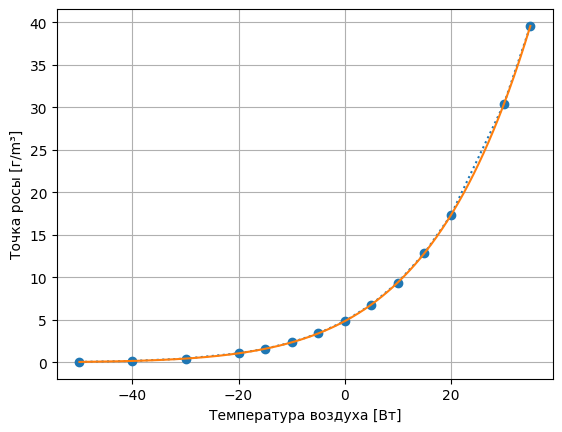

In [5]:
# Таблица влажности воздуха

# # Градусы Цельсия в Кельвины
# def c_to_k(t_celsius: float) -> float:
#     return Q(t_celsius, ureg.celsius).to(ureg.kelvin).magnitude

# def a_c_to_k(ts: List[float]) -> List[float]:
#     return [c_to_k(t) for t in ts]

# # Кельвины в градусы Цельсия
# def k_to_c(t_celsius: float) -> float:
#     return Q(t_celsius, ureg.kelvin).to(ureg.celsius).magnitude

# def a_k_to_c(ts: List[float]) -> List[float]:
#     return [k_to_c(t) for t in ts]



abs_hum_unit = ureg.gram/ureg.meter**3
abs_hum_unit_metric = ureg.kg/ureg.meter**3

air_table = [
    (Q(-50, ureg.celsius).to(ureg.kelvin), 0.063* abs_hum_unit,),
    (Q(-40, ureg.celsius).to(ureg.kelvin), 0.177* abs_hum_unit,),
    (Q(-30, ureg.celsius).to(ureg.kelvin), 0.455* abs_hum_unit,),
    (Q(-20, ureg.celsius).to(ureg.kelvin), 1.076* abs_hum_unit,),
    (Q(-15, ureg.celsius).to(ureg.kelvin), 1.608* abs_hum_unit,),
    (Q(-10, ureg.celsius).to(ureg.kelvin), 2.361* abs_hum_unit,),
    (Q(-5, ureg.celsius).to(ureg.kelvin), 3.411* abs_hum_unit,),
    (Q(0, ureg.celsius).to(ureg.kelvin), 4.852* abs_hum_unit,),
    (Q(5, ureg.celsius).to(ureg.kelvin), 6.801* abs_hum_unit,),
    (Q(10, ureg.celsius).to(ureg.kelvin), 9.403* abs_hum_unit,),
    (Q(15, ureg.celsius).to(ureg.kelvin), 12.83* abs_hum_unit,),
    (Q(20, ureg.celsius).to(ureg.kelvin), 17.3* abs_hum_unit,),
    (Q(30, ureg.celsius).to(ureg.kelvin), 30.36* abs_hum_unit,),
    (Q(35, ureg.celsius).to(ureg.kelvin), 39.58* abs_hum_unit,),
]
air_table_temperatures = [temp for temp, _humidity in air_table]
air_table_abs_humidies = [humidity for _temp, humidity in air_table]

air_table_temperatures_untyped = [x.magnitude for x in air_table_temperatures]
air_table_abs_humidies_untyped = [x.magnitude for x in air_table_abs_humidies]

air_table_linear = interpolate.interp1d(air_table_temperatures_untyped, air_table_abs_humidies_untyped)
# air_table_linear2 = interpolate.Akima1DInterpolator(air_table_temperatures_untyped, air_table_abs_humidies_untyped)
air_table_spline = interpolate.CubicSpline(air_table_temperatures_untyped, air_table_abs_humidies_untyped)

interpolate_fn = air_table_spline

def air_max_humidity(temp: float) -> float:
    return (interpolate_fn(temp.to(ureg.kelvin).magnitude)*abs_hum_unit).to(abs_hum_unit_metric)

temps = np.linspace(min(air_table_temperatures_untyped), max(air_table_temperatures_untyped), 1000)


# air_max_humidity(Q(22, ureg.celsius))
plt.plot(
    [x.to(ureg.celsius).magnitude for x in air_table_temperatures],
    [x.magnitude for x in air_table_abs_humidies],
    'o:',
)
plt.plot(
    [Q(x, ureg.kelvin).to(ureg.celsius).magnitude for x in temps],
    air_table_spline(temps),
    '-',
)
plt.xlabel("Температура воздуха [Вт]")
plt.ylabel("Точка росы [г/m³]")
plt.grid()
plt.show()

In [6]:
living_volume = (living_area*ceiling_height).to(ureg.meter**3)
living_volume

<Quantity(156.0, 'meter ** 3')>

In [7]:
required_airflow_by_people = required_air_per_person*people_count

required_airflow_by_living_volume = living_volume*living_space_airflow_k
required_airflow = max(required_airflow_by_people, required_airflow_by_living_volume)


tabulate.tabulate(
    tablefmt='html',
    tabular_data=[
        ["Жилой объём", living_volume],
        ["Приток по людям", required_airflow_by_people],
        ["Приток по воздухообмену", required_airflow_by_living_volume],
        ["Необходимый приток", required_airflow],
        # ["Точка росы", dew_point],
        # ["Необходимое количество воды для увлажнения приточного воздуха", required_water_volume_per_hour]
    ]
)

Жилой объём,156.0 meter ** 3
Приток по людям,90.0 meter ** 3 / hour
Приток по воздухообмену,156.0 meter ** 3 / hour
Необходимый приток,156.0 meter ** 3 / hour


In [8]:
def with_lower_bound(bound: Any) -> Callable:
    def decorator(fn: Callable) -> Callable:
        def wrapped(*args: Any, **kwargs: Any) -> Any:
            result = fn(*args, **kwargs)
            if result < bound:
                return bound
            else:
                return result
        return wrapped
    return decorator


# Энергетика вентиляции
# 1. Нагрев воздуха
@with_lower_bound(0*ureg.kilowatt)
def air_heat_power(required_airflow, street_temp, supply_air_temp) -> float:
    return (required_airflow*air_specific_heat_vol*(supply_air_temp-street_temp).to(ureg.kelvin)).to(ureg.kilowatt)


# 2. Увлажнение воды
@with_lower_bound(0*ureg.kilowatt)
def humidification_power(required_airflow, required_humidity, street_temp, street_humidity) -> float:
    dew_street_point = air_max_humidity(street_temp)
    dew_point = air_max_humidity(internal_temp)

    required_water_volume_per_hour = required_airflow * (dew_point * float(required_humidity) - dew_street_point * float(street_humidity))

    evaporation_energy = (Q(100, ureg.celsius) - water_starting_temp).to(ureg.kelvin)*water_specific_heat + water_specific_heat_vpr

    return (required_water_volume_per_hour*evaporation_energy).to(ureg.kilowatt)

air_heat_pwr = air_heat_power(required_airflow, street_temp, supply_air_temp)
# Тут для простоты считаем воздух на абсолютно сухим
humidification_pwr = humidification_power(required_airflow, required_humidity, street_temp, 0)

tabulate.tabulate(
    tablefmt='html',
    headers=["Результат"],
    tabular_data=[
        ["Мощность на нагрев воздуха", air_heat_pwr],
        ["Мощность на увлажнение", humidification_pwr],
        ["Суммарная мощность", sum([air_heat_pwr, humidification_pwr])],
    ]
)

,Результат
Мощность на нагрев воздуха,3.1781324404761895 kilowatt
Мощность на увлажнение,0.9951320828134712 kilowatt
Суммарная мощность,4.173264523289661 kilowatt


/home/victor/projects/home/vent-calc/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1398: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


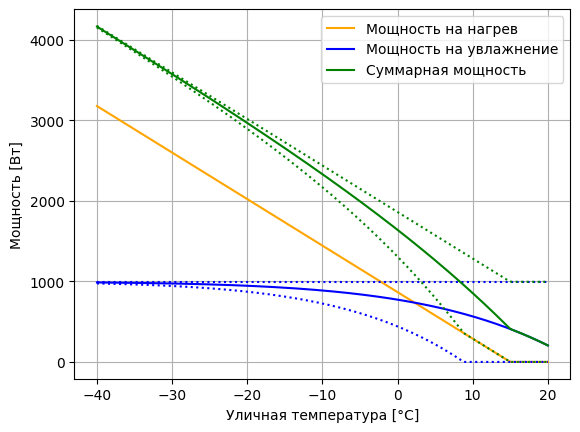

In [9]:
temperatures = np.linspace(-40, 20, 200)

air_heat_pwrs = [
    air_heat_power(required_airflow, Q(street_temp, ureg.celsius), supply_air_temp)
    for street_temp in temperatures
]

# Для простоты считаем что относительная влажность на улице равна относительной
# влажности необходимой нам в приточном воздухе
humidification_pwrs = [
    humidification_power(required_airflow, required_humidity, Q(street_temp, ureg.celsius), required_humidity)
    for street_temp in temperatures
]
humidification_pwrs_max = [
    humidification_power(required_airflow, required_humidity, Q(street_temp, ureg.celsius), 0*ureg.percent)
    for street_temp in temperatures
]
humidification_pwrs_min = [
    humidification_power(required_airflow, required_humidity, Q(street_temp, ureg.celsius), 100*ureg.percent)
    for street_temp in temperatures
]


summary_pwrs = [a+b for a, b in zip(air_heat_pwrs, humidification_pwrs)]
summary_pwrs_min = [a+b for a, b in zip(air_heat_pwrs, humidification_pwrs_min)]
summary_pwrs_max = [a+b for a, b in zip(air_heat_pwrs, humidification_pwrs_max)]


plt.plot(
    temperatures,
    Q.from_list([x.to(ureg.watt) for x in air_heat_pwrs]),
    '-',
    label="Мощность на нагрев",
    color='orange',
)

plt.plot(
    temperatures,
    Q.from_list([x.to(ureg.watt) for x in humidification_pwrs]),
    '-',
    color='blue',
    label="Мощность на увлажнение",
)
plt.plot(
    temperatures,
    Q.from_list([x.to(ureg.watt) for x in humidification_pwrs_min]),
    ':',
    color='blue',
)
plt.plot(
    temperatures,
    Q.from_list([x.to(ureg.watt) for x in humidification_pwrs_max]),
    ':',
    color='blue',
)

plt.plot(
    temperatures,
    Q.from_list([x.to(ureg.watt) for x in summary_pwrs]),
    '-',
    color='green',
    label="Суммарная мощность",
)

plt.plot(
    temperatures,
    Q.from_list([x.to(ureg.watt) for x in summary_pwrs_min]),
    ':',
    color='green',
)
plt.plot(
    temperatures,
    Q.from_list([x.to(ureg.watt) for x in summary_pwrs_max]),
    ':',
    color='green',
)
plt.xlabel("Уличная температура [°C]")
plt.ylabel("Мощность [Вт]")
plt.legend()
plt.grid()
plt.show()